# Seasonality analysis

In [167]:
import os
import datetime as dt
import pickle


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'      # S&P 500
# symbol = 'AAPL'       # Apple




# set maximum number of years to analyze
max_num_of_years = 5



# set number of days for rolling averages for full data plots
rolling_narrow_resolution = 50
rolling_wide_resolution = 200



# set number of day of rolling averages for annual data plots
annualRollingDays = 20


# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: ^GSPC

* **Max years to analyse**: 2022 until earliest 2018

In [168]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"
pickleFilename = f"{dirname}{os.path.sep}lastAnalysis.pkl"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
#df = ticker.history(period='max')

dataDownloaded = False

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")
    df.to_csv(historyFilename)
    dataDownloaded = True
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])

df = df[['Close']]


D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')
D(f'* Downloaded from internet: {dataDownloaded}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')


# set correct frequency
df = df.asfreq('B')

# fill up missing values
df = df.fillna(method='ffill')



D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _^GSPC_

* From 30.12.27 to 18.08.23

* Downloaded from internet: False

## Statistics:

              Close
count  24951.000000
mean     592.583494
std      945.919865
min        4.400000
25%       24.350000
50%      101.309998
75%      970.744995
max     4796.560059


## Data:

                  Close
Date                   
1927-12-30    17.660000
1928-01-02    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
...                 ...
2023-08-14  4489.720215
2023-08-15  4437.859863
2023-08-16  4404.330078
2023-08-17  4370.359863
2023-08-18  4369.709961

[24951 rows x 1 columns]


In [169]:
# prepare range of max 5 years or smaller if dataframe is smaller
firstDay = pd.to_datetime(str((df.index.year.min()+1 if ((df.index.year.max()-1) - (df.index.year.min()+1)) < max_num_of_years else df.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(df.index.year.max()-1) + '-12-31')
rangeMax5yrs = pd.date_range(firstDay, lastDay, freq='D')

# get actual number of calculated years for dataframe
rangeNumOfYears = rangeMax5yrs.max().year - rangeMax5yrs.min().year + 1

# save information for backtrader
backtestInfo = {
    'historyFilename': historyFilename,
    'rangeMax5yrs' : rangeMax5yrs,
}
pickle.dump(backtestInfo, open(pickleFilename, 'wb'))

# Prepare new dataframe in long form for annual data distribution
def dfToLongForm(inputDf, freq = 'd', colName = 'Day', colContent = '%m-%d', withFill = True, dropLeap = True):
    # Create new dataframe
    annualDf = pd.DataFrame(data=inputDf)

    # set correct frequency for better comparison
    annualDf = annualDf.asfreq(freq)

    # fill up missing values for better comparison
    annualDf = annualDf.fillna(method='ffill') if withFill else annualDf

    # Drop Feb. 29th of leap years for better comparison
    annualDf = annualDf[~((annualDf.index.month == 2) & (annualDf.index.day == 29))] if dropLeap else annualDf

    # Create year and month columns
    annualDf['Year'], annualDf[colName] = annualDf.index.year, annualDf.index.strftime(colContent)

    # crop dataframe to max 5 last full years
    annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()]
    
    # remove date index and return to numbered index
    annualDf = annualDf.reset_index()
    
    # remove date column which was left over from removing date index
    annualDf = annualDf.drop('Date', axis=1)
    
    return annualDf


annualDf = dfToLongForm(df.assign(**{'rolling average': df['Close'].rolling(annualRollingDays).mean()}))
    
# set to multiindex: 1st level 'Day', 2nd level 'Year'
annualDf = annualDf.set_index(['Year', 'Day'])

# reorder by index level 'Day'
annualDf = annualDf.sort_index(level='Year')

D('## Initial data overview')
annualDf
#annualDf.index


## Initial data overview

Close  rolling average
Year Day                                
2018 01-01  2673.610107      2668.105042
     01-02  2695.810059      2671.417041
     01-03  2713.060059      2675.606543
     01-04  2723.989990      2679.957043
     01-05  2743.149902      2684.539539
...                 ...              ...
2022 12-27  3829.250000      3930.646509
     12-28  3783.219971      3915.802002
     12-29  3849.280029      3904.437500
     12-30  3839.500000      3892.827502
     12-31  3839.500000      3892.827502

[1825 rows x 2 columns]

In [170]:
#periodNames = ['seasonal_' + str(i) for i in periods]

decompDf = pd.DataFrame(data=df)

# crop dataframe to max 5 last full years
decompDf = decompDf[rangeMax5yrs.min():pd.to_datetime('today')]

# prepare the 3 dataframes for seasonal, trend and residual
seasonalDecompDf = pd.DataFrame()
trendDecompDf = pd.DataFrame()
residDecompDf = pd.DataFrame()

# simplest form of STL
decomposeSimpleStl = STL(decompDf['Close'], period=365)
decomposeSimpleRes = decomposeSimpleStl.fit()

seasonalDecompDf['Simple STL'] = decomposeSimpleRes.seasonal
trendDecompDf['Simple STL'] = decomposeSimpleRes.trend
residDecompDf['Simple STL'] = decomposeSimpleRes.resid

# simplest form of STL
decomposeRobustStl = STL(decompDf['Close'], period=365, robust=True)
decomposeRobustRes = decomposeSimpleStl.fit()

seasonalDecompDf['Robust STL'] = decomposeRobustRes.seasonal
trendDecompDf['Robust STL'] = decomposeRobustRes.trend
residDecompDf['Robust STL'] = decomposeRobustRes.resid

# prepare annual dataframes with multiindex including the rolling averages
annunalSeasonalDecompDf = dfToLongForm(seasonalDecompDf.assign(**{'rolling average': seasonalDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))
annunalTrendDecompDf = dfToLongForm(trendDecompDf.assign(**{'rolling average': trendDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))
annunalResidDecompDf = dfToLongForm(residDecompDf.assign(**{'rolling average': residDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))

#pd.set_option('display.max_rows', None)

D('## Seasonal decomposition')
print(seasonalDecompDf)
print(annunalSeasonalDecompDf)

## Seasonal decomposition

            Simple STL  Robust STL
Date                              
2018-01-01   66.772235   66.772235
2018-01-02   65.019625   65.019625
2018-01-03   59.793028   59.793028
2018-01-04   64.076310   64.076310
2018-01-05   57.766775   57.766775
...                ...         ...
2023-08-14  464.093134  464.093134
2023-08-15  441.323577  441.323577
2023-08-16  386.143104  386.143104
2023-08-17  388.078954  388.078954
2023-08-18  390.138829  390.138829

[1470 rows x 2 columns]
      Simple STL  Robust STL  rolling average  Year    Day
0      66.772235   66.772235              NaN  2018  01-01
1      65.019625   65.019625              NaN  2018  01-02
2      59.793028   59.793028              NaN  2018  01-03
3      64.076310   64.076310              NaN  2018  01-04
4      57.766775   57.766775              NaN  2018  01-05
...          ...         ...              ...   ...    ...
1820 -112.185353 -112.185353       -70.062409  2022  12-27
1821 -149.676419 -149.676419       -78.964719  2

In [171]:
monthlySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('M').mean(), freq='M', colName='Month', colContent='%B', withFill=False, dropLeap=False)
monthlySeasonalDecompDf.head()

,Simple STL,Robust STL,Year,Month
0,160.085164,160.085164,2018,January
1,166.471401,166.471401,2018,February
2,129.581147,129.581147,2018,March
3,100.373517,100.373517,2018,April
4,92.546289,92.546289,2018,May


In [172]:
weekdailySeasonalDecompDf = dfToLongForm(seasonalDecompDf, freq='B', colName='Weekday', colContent='%A', withFill=False, dropLeap=False)
weekdailySeasonalDecompDf

,Simple STL,Robust STL,Year,Weekday
0,66.772235,66.772235,2018,Monday
1,65.019625,65.019625,2018,Tuesday
2,59.793028,59.793028,2018,Wednesday
3,64.076310,64.076310,2018,Thursday
4,57.766775,57.766775,2018,Friday
...,...,...,...,...
1300,-102.518485,-102.518485,2022,Monday
1301,-112.185353,-112.185353,2022,Tuesday
1302,-149.676419,-149.676419,2022,Wednesday
1303,-75.350797,-75.350797,2022,Thursday


In [173]:
quarterlySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('Q').mean(), freq='Q', colName='Quarter', colContent='%B', withFill=False, dropLeap=False)
quarterlySeasonalDecompDf

,Simple STL,Robust STL,Year,Quarter
0,151.725723,151.725723,2018,March
1,108.852767,108.852767,2018,June
2,228.112612,228.112612,2018,September
3,-172.567594,-172.567594,2018,December
4,-146.886480,-146.886480,2019,March
5,-10.432580,-10.432580,2019,June
6,33.214595,33.214595,2019,September
7,73.028117,73.028117,2019,December
8,64.824749,64.824749,2020,March
9,-97.656538,-97.656538,2020,June


In [174]:
weeklySeasonalDecompDf = dfToLongForm(seasonalDecompDf.resample('W').mean(), freq='W', colName='Week', colContent='%V', withFill=False, dropLeap=False)
weeklySeasonalDecompDf

,Simple STL,Robust STL,Year,Week
0,62.685594,62.685594,2018,01
1,79.611122,79.611122,2018,02
2,200.137355,200.137355,2018,03
3,248.699816,248.699816,2018,04
4,230.625658,230.625658,2018,05
...,...,...,...,...
255,-42.631120,-42.631120,2022,47
256,-13.983774,-13.983774,2022,48
257,-66.991710,-66.991710,2022,49
258,-64.344560,-64.344560,2022,50


In [175]:
# setup general figure size
generalPlotWidth = 15
generalSubPlotHight = 3

# activate retina mode
plt.rcParams['figure.dpi'] = 200

# configure theme and style
sns.set_theme('paper')
sns.set_style('darkgrid')


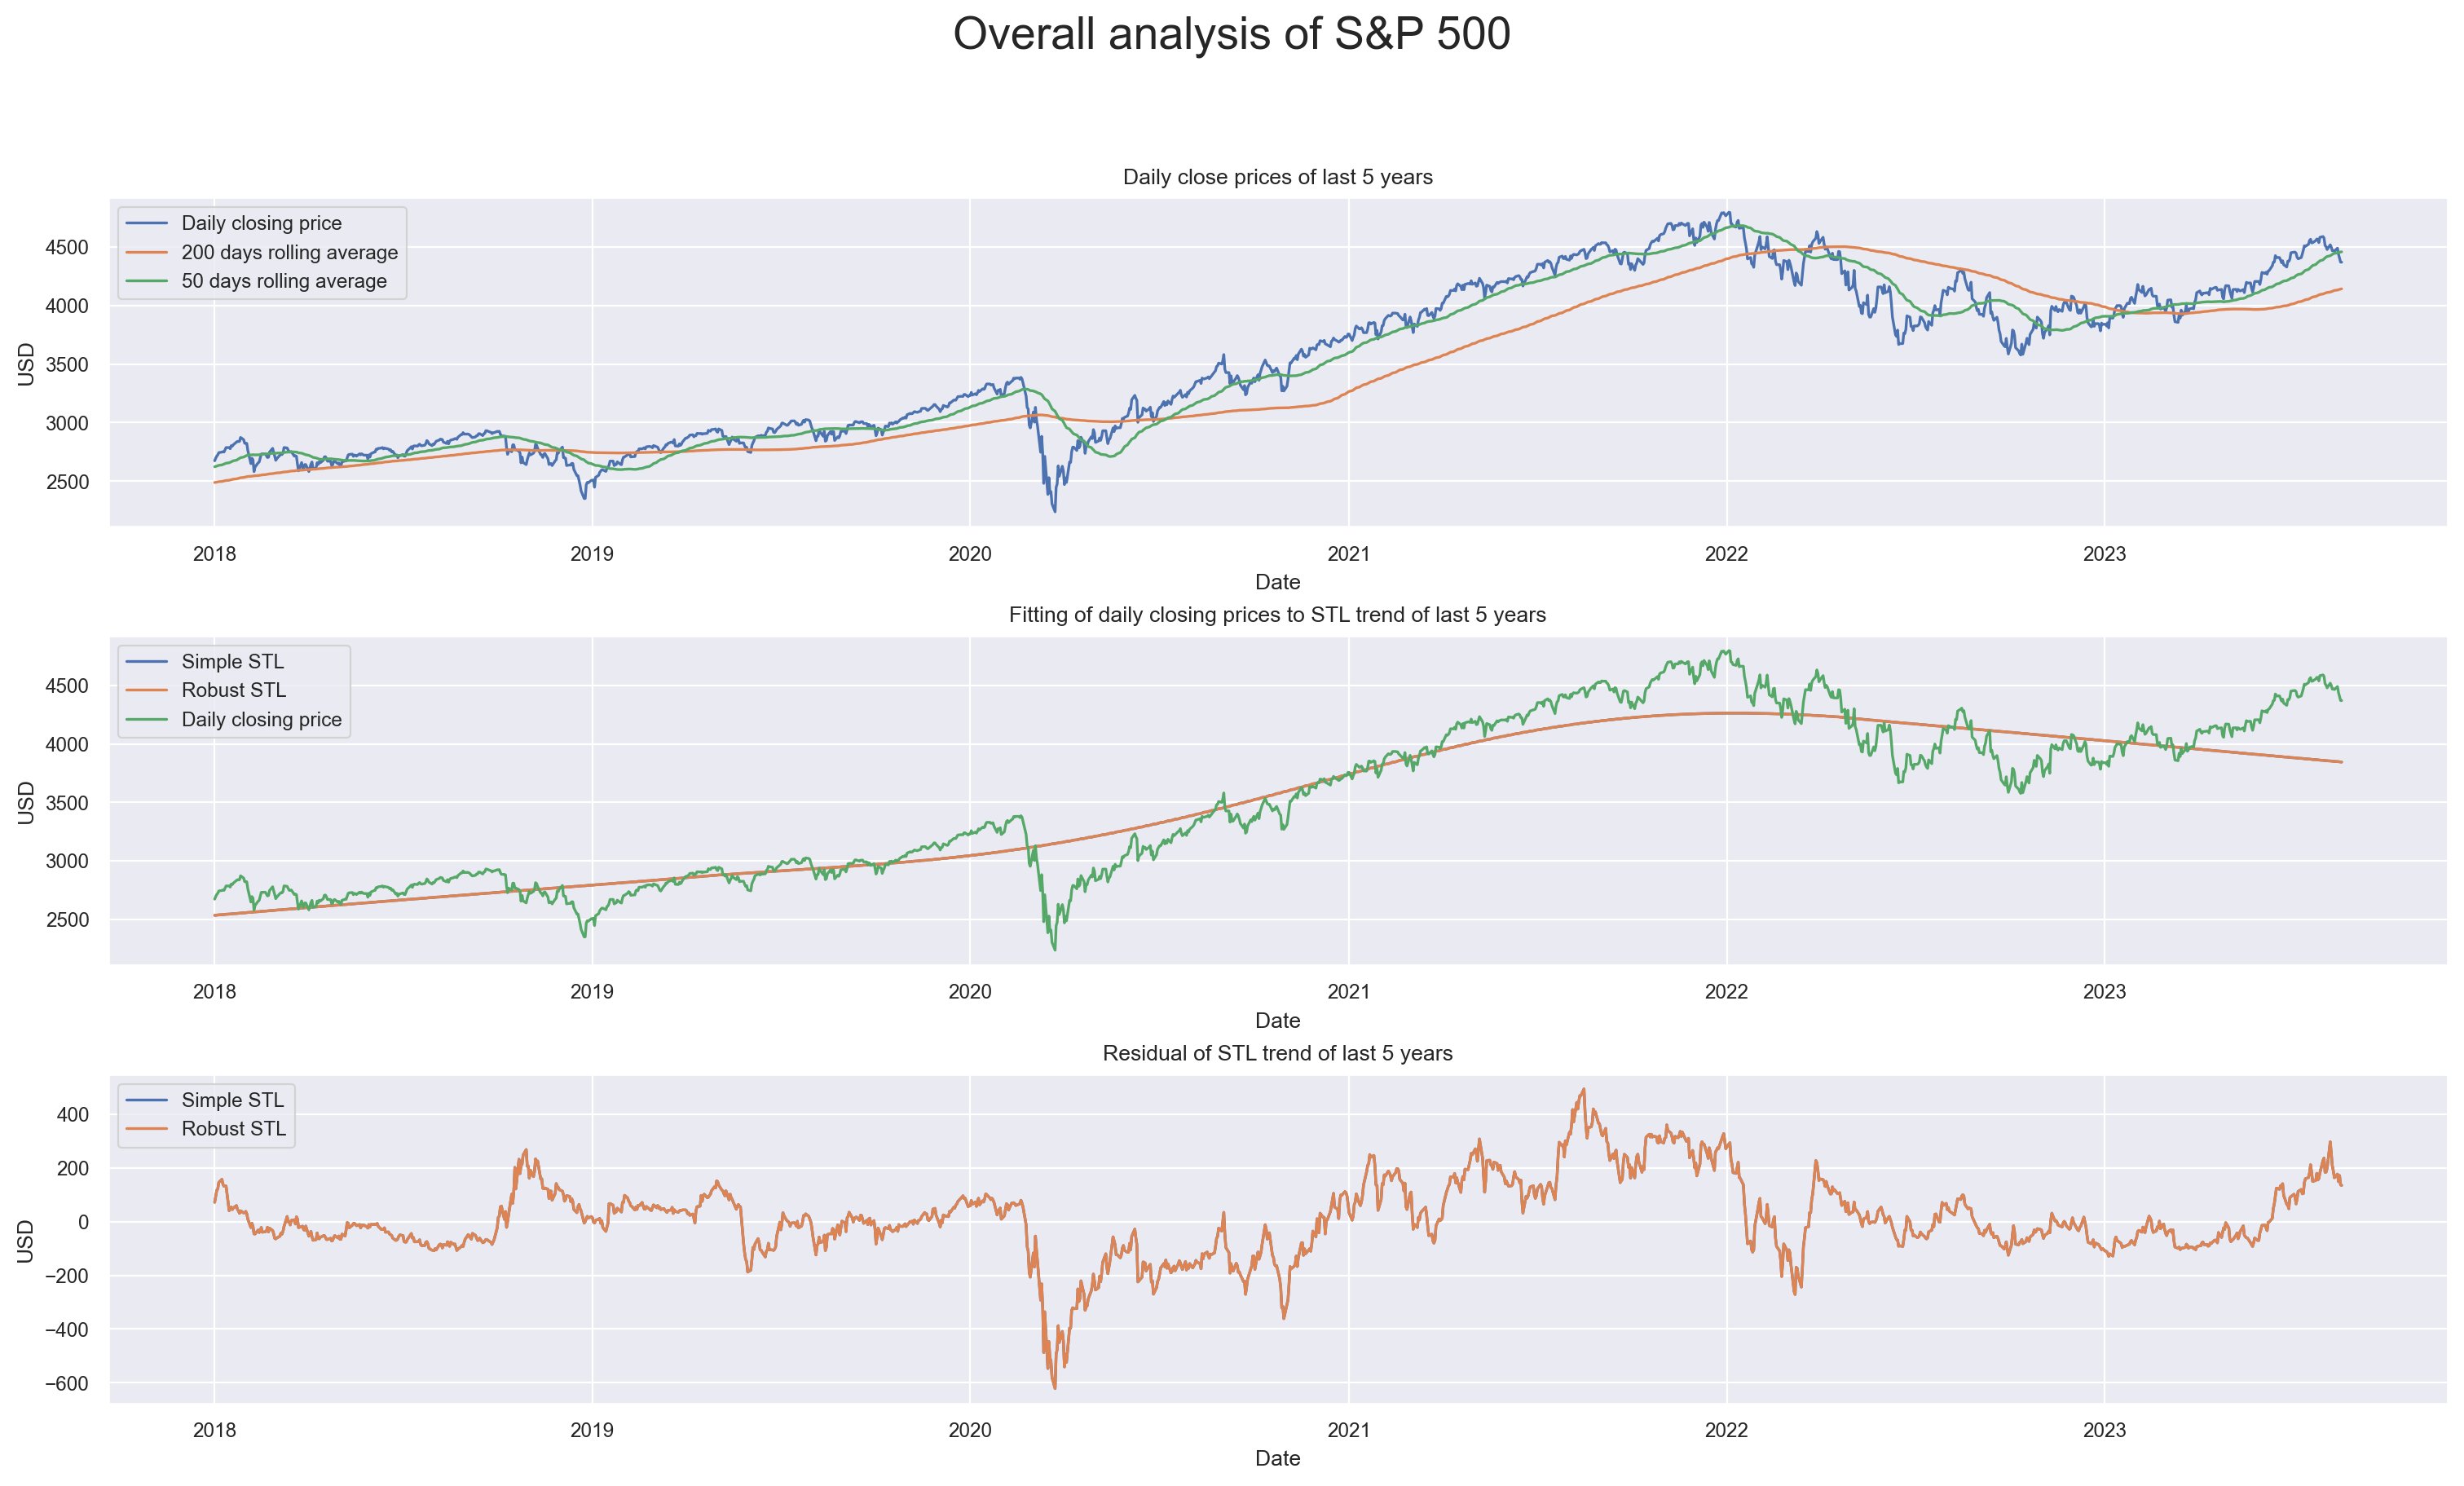

In [176]:

numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
fig.suptitle(f'Overall analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf.rename(columns={'Close':'Daily closing price'}, inplace=True)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Daily close prices of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall closing prices of last x years with STL trend
overallDf = pd.DataFrame(data=trendDecompDf)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
overallDf['Daily closing price'] = df[rangeMax5yrs.min():pd.to_datetime('today')]['Close']
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Fitting of daily closing prices to STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall STL residual of last x years with STL trend
overallDf = pd.DataFrame(data=residDecompDf)
sns.lineplot(data=overallDf[['Simple STL', 'Robust STL']], dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Residual of STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1

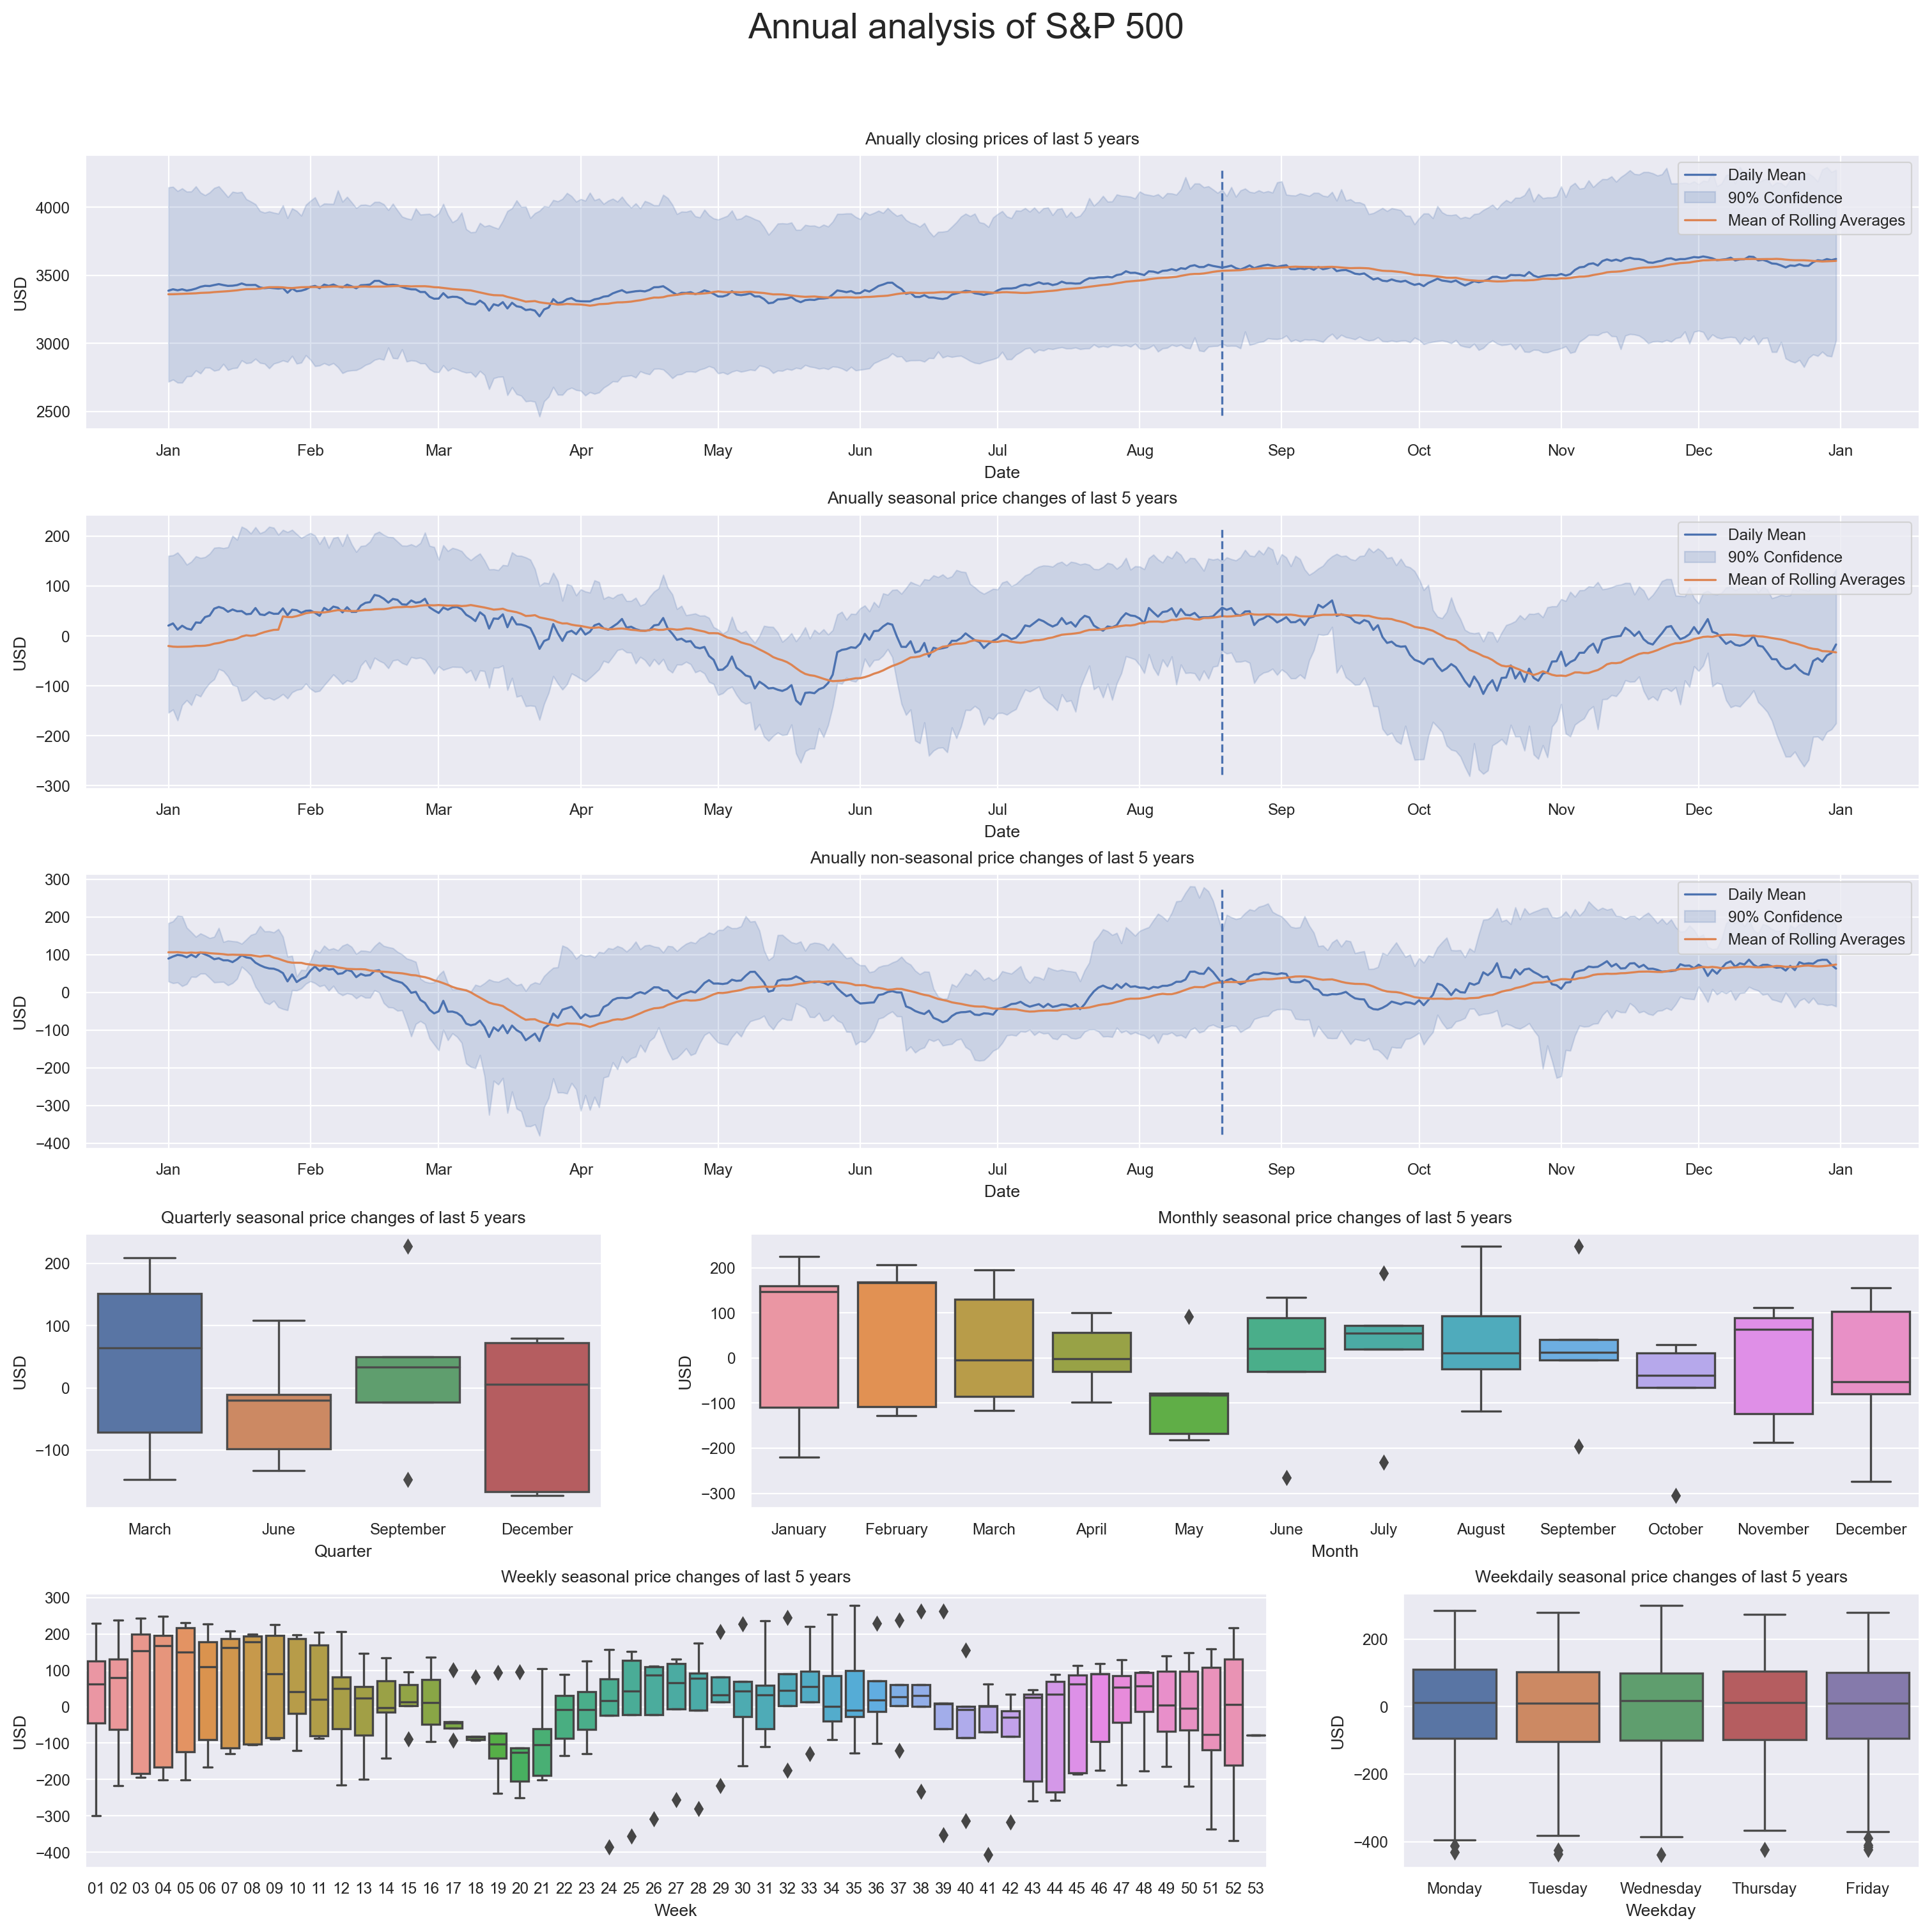

In [177]:
axs = []
numSubPlots = 5

fig = plt.figure(layout="constrained", figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots))
gs = GridSpec(5, 3, figure=fig)
sns.set_theme('paper')
fig.suptitle(f'Annual analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

axs.append(fig.add_subplot(gs[0, :]))   # add plot over full line
# Plot annual closing prices with confidence band
sns.lineplot(data=annualDf, x='Day', y='Close', ax=axs[currentAxis], sort=True)
sns.lineplot(data=annualDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually closing prices of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[1, :]))   # add plot over full line
# Plot annual seasonal prices with confidence band
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
sns.lineplot(data=annunalSeasonalDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalSeasonalDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[2, :]))   # add plot over full line
# Plot annual residual prices with confidence band
sns.lineplot(data=annunalResidDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalResidDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually non-seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


axs.append(fig.add_subplot(gs[3, 0]))
# Plot quarterly seasonal prices
sns.boxplot(data=quarterlySeasonalDecompDf, x='Quarter', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Quarterly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[3, 1:]))
# Plot monthly seasonal prices
sns.boxplot(data=monthlySeasonalDecompDf, x='Month', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Monthly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, :-1]))
# Plot weekly seasonal prices
sns.boxplot(data=weeklySeasonalDecompDf, x='Week', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekly seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1

axs.append(fig.add_subplot(gs[4, 2]))
# Plot weekdaily seasonal prices
sns.boxplot(data=weekdailySeasonalDecompDf, x='Weekday', y='Simple STL', ax=axs[currentAxis])
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_title(f'Weekdaily seasonal price changes of last {rangeNumOfYears} years')
currentAxis += 1
